In [3]:
import galsim
import matplotlib.pyplot as plt
import numpy as np
from calc_ellipticity import SimpleImageModel,addPoissonNoiseSNR
from calc_moments import calc_ellip
from IPython.display import Math
from lenstronomy.Cosmo.micro_lensing import einstein_radius
import webbpsf

In [3]:
d_s = 8000
d_l = 4000              # pc
M0 = 500               # M_sol
theta_E = einstein_radius(M0, d_l, d_s)     # arcsec


x_l, y_l = (0.1*theta_E, 0.2*theta_E)
x_ps, y_ps = (0, 0)

beta = np.sqrt((x_l-x_ps)**2+(y_l-y_ps)**2)
theta_p = (beta + np.sqrt(beta*beta+4*theta_E*theta_E))/2
theta_n = (beta - np.sqrt(beta*beta+4*theta_E*theta_E))/2
x = (theta_p/theta_E)**4
A_p = x/(x-1)
x = (theta_n/theta_E)**4
A_n = -x/(x-1)
assert A_p >= 0 and A_n >= 0

x_p = theta_p/beta*(x_ps - x_l) + x_l
y_p = theta_p/beta*(y_ps - y_l) + y_l
x_n = theta_n/beta*(x_ps - x_l) + x_l
y_n = theta_n/beta*(y_ps - y_l) + y_l

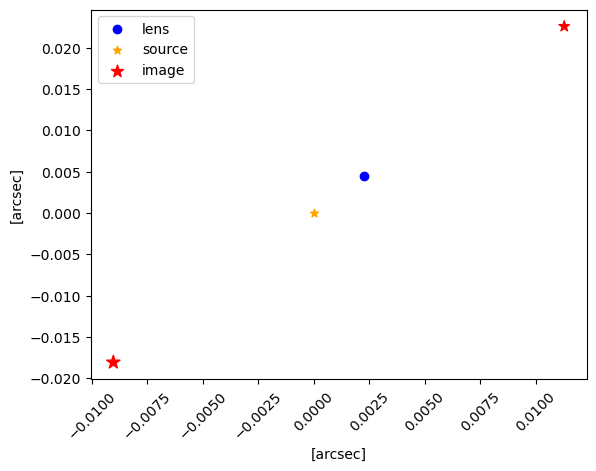

In [8]:
size = plt.rcParams['lines.markersize'] ** 2

plt.scatter((x_l,), (y_l,), label='lens', color='blue')
plt.scatter((x_ps,), (y_ps,), label='source', marker='*', color='orange')
plt.scatter((x_p, x_n), (y_p, y_n), label='image', marker='*', color='red', s=[size*A_p, size*A_n])
plt.xlabel('[arcsec]')
plt.ylabel('[arcsec]')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Add noise and calculate the result

In [4]:
M0 = 500
dl = 4000
ds = 8000
theta_E = einstein_radius(M0, dl, ds)

In [20]:
nrc = webbpsf.NIRCam()
psf = nrc.calc_psf()
deltaPix = psf[1].header['PIXELSCL']
image = galsim.Image(psf[1].data)
psf = galsim.InterpolatedImage(image, scale=deltaPix)

fwhm=0.08
figsize = (fwhm + theta_E)*5
num_pix = int(figsize/deltaPix)

In [21]:
mom = image.FindAdaptiveMom()

In [28]:
mom.observed_shape

galsim.Shear((-0.008121049172762584+0.0011282672032210833j))

In [31]:
s1 = galsim.Shear(g1=0.05, g2=0.05)
s2 = galsim.Shear(eta1=0.07, eta2=-0.1)

In [34]:
s1 + s2

galsim.Shear((0.08501849481591325+0.0004231885871280534j))

In [22]:
mom.observed_e1

-0.016241006553173065

In [23]:
mom.observed_e2

0.0022563827224075794

In [6]:
mymodel = SimpleImageModel(deltaPix, num_pix, num_pix, (0, 0), psf)

In [7]:
m = 500
u = 0.2
theta_E = einstein_radius(m, dl, ds)

In [8]:
flux = 100                  # relative value, will be rescaled for SNR
sky_level = 1
snr = 100

image and image with poisson noise

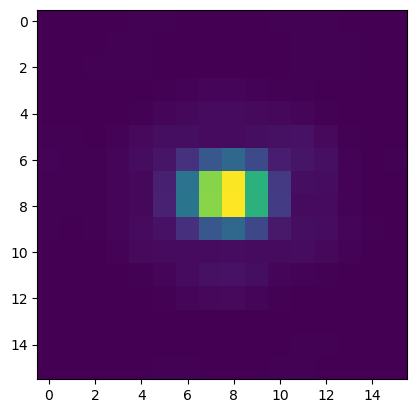

23.930858684059114


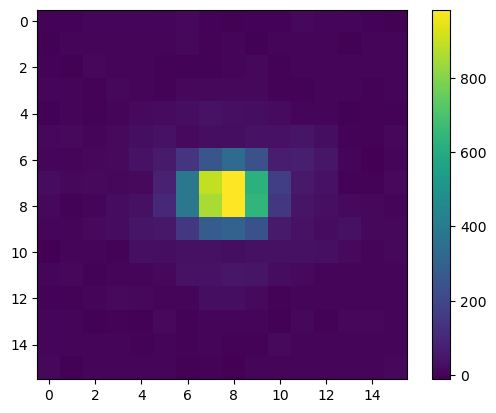

In [9]:
image = mymodel.mock_image(theta_E, 0, 0, theta_E*u, 0, flux)
image_old = image.copy()
plt.imshow(image_old.array)
plt.show()
ratio = addPoissonNoiseSNR(image, snr, sky_level)
print(ratio)
plt.imshow(image.array)
plt.colorbar()
plt.show()

In [10]:
from calc_ellipticity import _addPoissonNoiseSNR_2

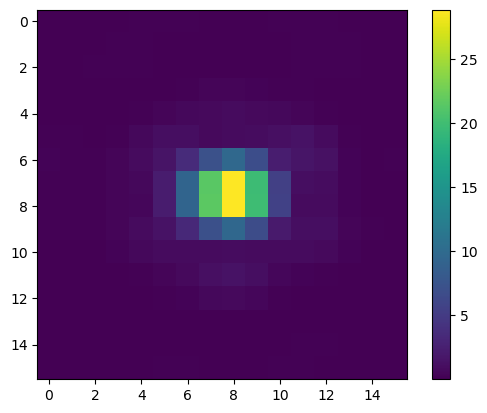

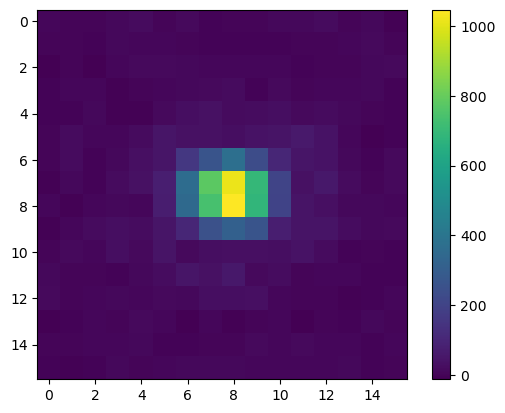

36.016241364032396


In [11]:
image = mymodel.mock_image(theta_E, 0, 0, theta_E*0.3, 0, flux)
image_old = image.copy()
plt.imshow(image.array)
plt.colorbar()
plt.show()
ratio = _addPoissonNoiseSNR_2(image, snr, sky_level)
plt.imshow(image.array)
plt.colorbar()
plt.show()
print(ratio)

In [12]:
mom_old = image_old.FindAdaptiveMom()
e_real = mom_old.observed_shape.e
mom = galsim.hsm.FindAdaptiveMom(image)
e_obs = mom.observed_shape.e
sig = mom.moments_sigma
Ne = ratio*flux
sky = ratio*sky_level
R2 = 1
sigma_sky = sig*sig/(R2*Ne)*np.sqrt(4*np.pi*sky)
sigma_star = 1/R2 * np.sqrt(64/(27*Ne))
# Math(f'{sigma_sky=:5f}, {sigma_star=:5f}')
sigma = np.sqrt(sigma_sky**2 + sigma_star**2)

Math('$\\sigma_{{sky}} = {:.5f}, \\sigma_{{star}} = {:.5f}\\\\e_{{real}} = {:.5f}\\\\e_{{obs}} = {:.5f} \\pm {:.5f}$'.format(sigma_sky, sigma_star, e_real, e_obs, sigma))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

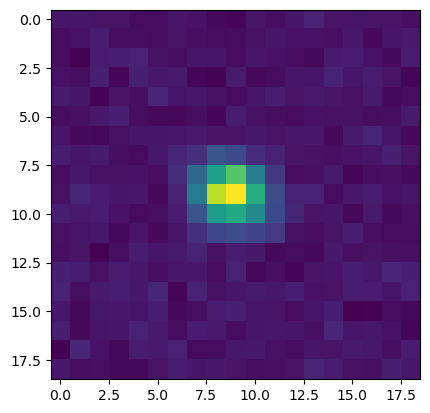

In [16]:
from calc_ellipticity import ellipticity_image_mock
res = ellipticity_image_mock(deltaPix, fwhm, 0, 0, theta_E*0.5, theta_E*0.1, theta_E, 100, True, True, snr=50, sky_level=5)
plt.imshow(res['image'].array)
Math(r'$e = {:.5f} \pm {:.5f}$'.format(res['e'], res['e_err']))

## figures add noise

In [17]:
# lets vary mass
add_noise = True
SNR = 100
image_2d = []
us = np.linspace(0.1, 0.5, 3)
ms = [100, 200, 500, 1000]

flux = 100
sky = 5
mymodel = SimpleImageModel(deltaPix, 20, 20, (0, 0), psf)

for u in us:
    images = []
    for m in ms:
        theta_E = einstein_radius(m, dl, ds)
        image = mymodel.mock_image(theta_E, 0, 0, theta_E*u, 0, flux)
        if add_noise:
            addPoissonNoiseSNR(image, SNR, sky)
        images.append(image)
    image_2d.append(images)

In [18]:
delta_m = np.log10(flux/sky)*2.5

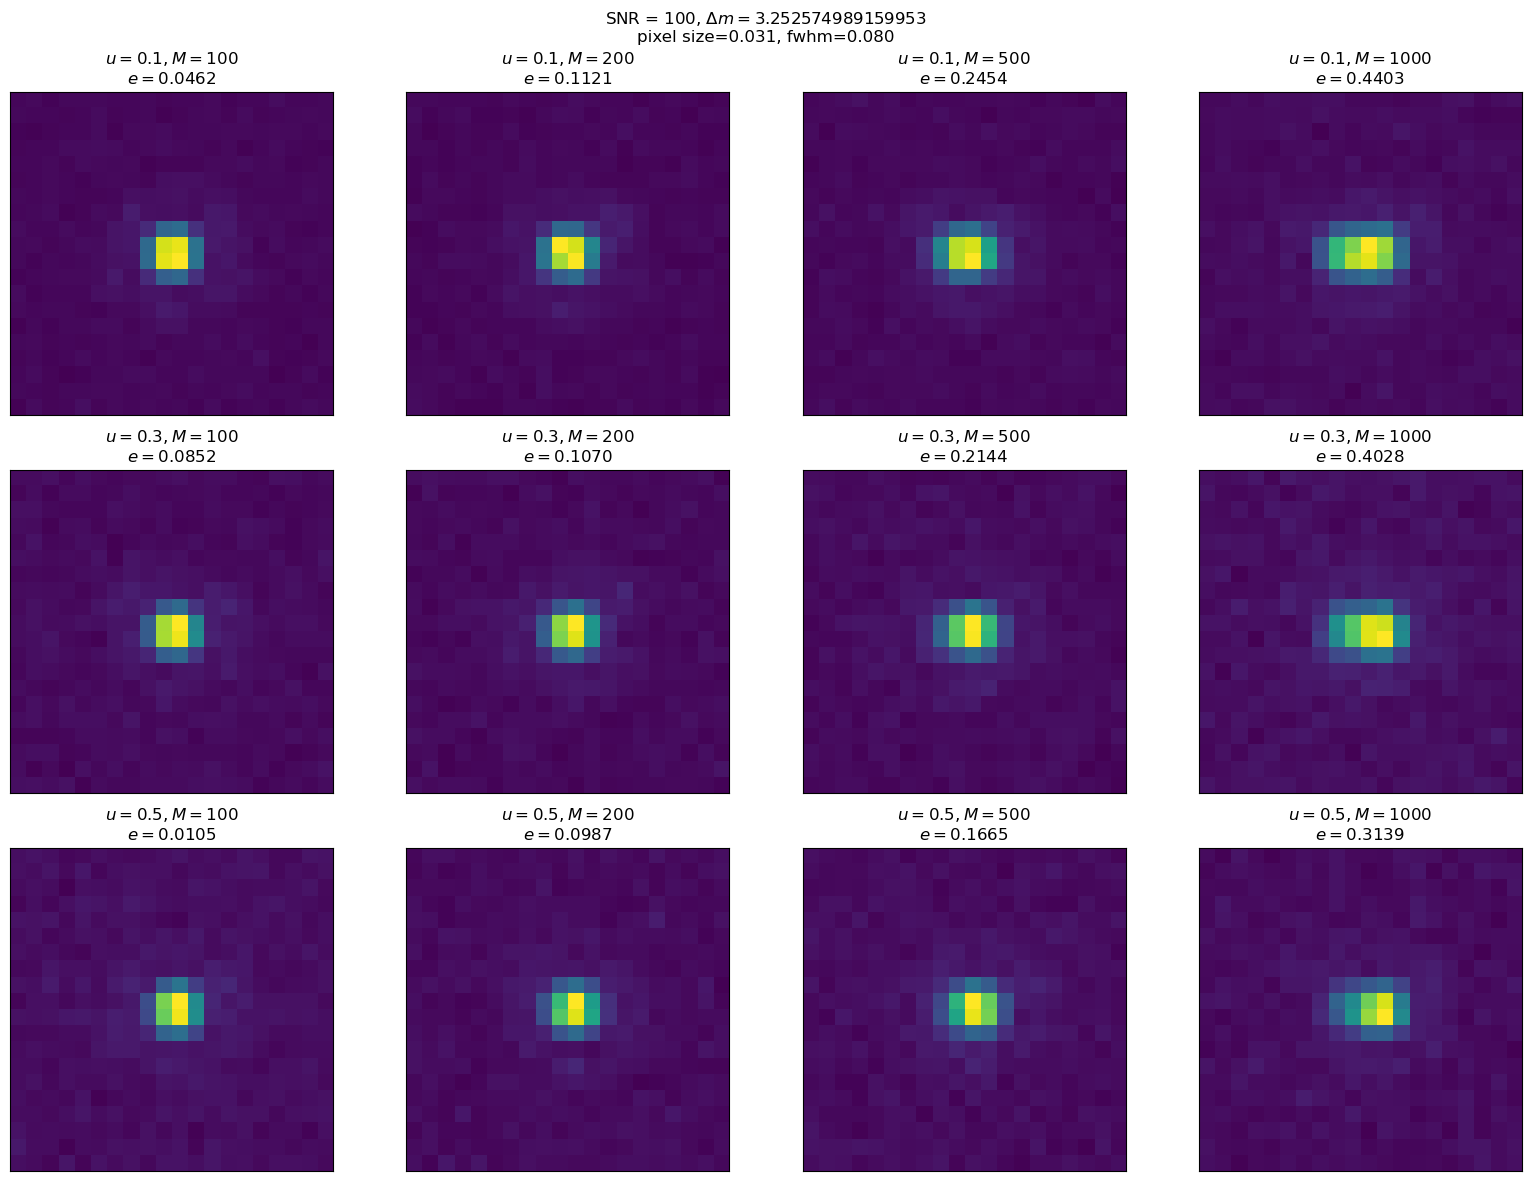

In [19]:
Nrow = 3
Ncol = 4
fig, axes = plt.subplots(Nrow, Ncol, figsize=(4*Ncol, 4*Nrow))
for i in range(Nrow):
    for j in range(Ncol):
        ax = axes[i,j]
        ax.imshow(image_2d[i][j].array)
        ax.set_title('$u = {:.1f}, M = {}$\n$e = {:.4f}$'.format(us[i], ms[j], galsim.hsm.FindAdaptiveMom(image_2d[i][j]).observed_shape.e))
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle(f'SNR = {SNR}, $\\Delta m={delta_m}$\npixel size={deltaPix:.3f}, fwhm={fwhm:.3f}')
fig.tight_layout()
plt.show()